In [141]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
from matplotlib.patches import Arc
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []
        self.autoscale = True

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = self.autoscale)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = self.autoscale)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        
        for circle in self.scenes[self.i].circles:
            self.ax.add_patch(circle)
#             circle = Arc()
#             self.ax.add_patch()
            
        if autoscaling:
            self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[], circles =[]):
        self.points=points
        self.lines=lines
        self.circles = circles

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self, scale = True):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()

        ax = plt.axes(autoscale_on = False)
        if scale is False:
            ax.set(xlim=plt.xlim, ylim = plt.ylim)
        self.callback.set_axes(ax)
        self.callback.autoscale = scale
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw(scale)

In [142]:
from typing import Optional


class Point:
    precision = 4

    def __init__(self, x: float, y: float):
        # self.x = round(x, Point.precision)
        # self.y = round(y, Point.precision)
        self.x = x
        self.y = y

        self.arc = None  # type: Optional[RBNode]
        self.edge = None  # type: Optional[HalfEdge]
        self.orderingY = self.y

    def setOrdering(self, y):
        self.orderingY = y
        # self.orderingY = round(y, Point.precision)

    def toPQ(self) -> tuple[float, 'Point']:
        """returns tuple containing ordering y and point itself, useful if storing in priority queue"""
        return -self.orderingY, self

    def __hash__(self):
        return hash(self.x) * hash(self.y)

    def __repr__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"

    def __eq__(self, other):
        # todo do setu moze lepiej by bylo tez sprawdzac arc?
        if other is None:
            return False
        return self.x == other.x and self.y == other.y


class HalfEdge:
    def __init__(self):
        self.start = None  # type: Optional[Point]
        self.end = None  # type: Optional[Point]

    def __repr__(self):
        return "[" + str(self.start) + " -> " + str(self.end) + "]"

    def __hash__(self):
        return hash(self.start) * hash(self.end)

    def __eq__(self, other):
        if other is None:
            return False
        return (self.start == other.start and self.end == other.end) or \
               (self.start == other.end and self.end == other.end)


class RBNode:
    def __init__(self, point: Point, color=1, parent=None, left=None, right=None, leftHalfEdge=None,
                 rightHalfEdge=None):
        self.parent = parent  # type: Optional[RBNode]
        self.left = left  # type: Optional[RBNode]
        self.right = right  # type: Optional[RBNode]
        self.color = color

        self.point = point  # type: Point
        self.leftHalfEdge = HalfEdge() if leftHalfEdge is None else leftHalfEdge  # type: Optional[HalfEdge]
        self.rightHalfEdge = HalfEdge() if rightHalfEdge is None else rightHalfEdge  # type: Optional[HalfEdge]
        self.prev = None  # type: Optional[RBNode]
        self.next = None  # type: Optional[RBNode]
        self.triggeredBy = None  # type: Optional[Point]

In [143]:
from math import sqrt
from typing import Optional

def getIntersectionOfParabolas(p1: Point, p2: Point, y: float) -> Point:
    """compute intersection of parabolas from p1 and p2 at x coordinate"""
    if p1.y == p2.y:
        px = (p1.x + p2.x) / 2
    elif p1.y == y:
        px = p1.x
    elif p2.y == y:
        px = p2.x
    else:
        d1 = 0.5 / (p1.y - y)
        d2 = 0.5 / (p2.y - y)

        a = d1 - d2
        b = -2.0 * (d1 * p1.x - d2 * p2.x)
        c = (p1.y ** 2 + p1.x ** 2 - y ** 2) * d1 - (p2.y ** 2 + p2.x ** 2 - y ** 2) * d2

        px = (-b + sqrt(b ** 2 - 4 * a * c)) / (2 * a)

    return Point(px, y)


"""
https://math.stackexchange.com/questions/213658/get-the-equation-of-a-circle-when-given-3-points

"""

def getConvergencePoint(point1: Point, point2: Point, point3: Point) -> tuple[Optional[Point], Optional[float]]:
    # print("points",point1, point2, point3)

    p1 = complex(point1.x, point1.y)
    p2 = complex(point2.x, point2.y)
    p3 = complex(point3.x, point3.y)

    w = (p3 - p1) / (p2 - p1)
    if w.imag == 0:
        return None, None
    c = (p2 - p1) * (w - abs(w) ** 2) / (2j * w.imag) + p1  # type: complex
    r = abs(p1 - c)  # type: float


    center = Point(c.real, c.imag)

    return center, center.y - r

In [144]:
from typing import Optional
from math import inf

"""
Implementation of red black tree from
https://github.com/keon/algorithms/blob/master/algorithms/tree/red_black_tree/red_black_tree.py
modified to support operations on Arcs, deleted some unused methods
"""

class RBTree:
    def __init__(self):
        self.root = None  # type: Optional[RBNode]

    def createRoot(self, node: RBNode) -> None:
        self.root = node
        node.color = 0

    def isEmpty(self) -> bool:
        return self.root is None

    def getNodeAbove(self, point: Point) -> Optional[RBNode]:
        """returns node above intersection made by point or None if dont exist"""
        if self.isEmpty():
            return None
        node = self.root

        while True:
            leftIntersection = Point(-inf, point.y)
            rightIntersection = Point(inf, point.y)
            # print("       node", node.point, node.prev, node.next)
            if node.prev is not None:
                leftIntersection = getIntersectionOfParabolas(node.prev.point, node.point, point.y)

            if node.next is not None:
                rightIntersection = getIntersectionOfParabolas(node.point, node.next.point, point.y)
            # print("     point", point, "left inter", leftIntersection, "right inter", rightIntersection)
            if point.x < leftIntersection.x:
                node = node.left
            elif point.x > rightIntersection.x:
                node = node.right
            else:
                return node

    def insertBefore(self, beforeNode: RBNode, toInsert: RBNode) -> None:
        if beforeNode.left is None:
            beforeNode.left = toInsert
            toInsert.parent = beforeNode
        else:
            beforeNode.prev.right = toInsert
            toInsert.parent = beforeNode.prev

        toInsert.prev = beforeNode.prev

        if toInsert.prev is not None:
            toInsert.prev.next = toInsert

        toInsert.next = beforeNode
        beforeNode.prev = toInsert

        self.fix_insert(toInsert)

    def insertAfter(self, afterNode: RBNode, toInsert: RBNode) -> None:
        if afterNode.right is None:
            afterNode.right = toInsert
            toInsert.parent = afterNode
        else:
            afterNode.next.left = toInsert
            toInsert.parent = afterNode.next

        toInsert.next = afterNode.next

        if toInsert.next is not None:
            toInsert.next.prev = toInsert

        toInsert.prev = afterNode
        afterNode.next = toInsert

        self.fix_insert(toInsert)

    def replace(self, oldNode: RBNode, newNode: RBNode) -> None:
        self.transplant(oldNode, newNode)
        newNode.left = oldNode.left
        newNode.right = oldNode.right

        if newNode.left is not None:
            newNode.left.parent = newNode

        if newNode.right is not None:
            newNode.right.parent = newNode

        newNode.prev = oldNode.prev
        newNode.next = oldNode.next

        if newNode.prev is not None:
            newNode.prev.next = newNode

        if newNode.next is not None:
            newNode.next.prev = newNode

        newNode.color = oldNode.color

    def left_rotate(self, node):
        # set the node as the left child node of the current node's right node
        right_node = node.right
        if right_node is None:
            return
        else:
            # right node's left node become the right node of current node
            node.right = right_node.left
            if right_node.left is not None:
                right_node.left.parent = node
            right_node.parent = node.parent
            # check the parent case
            if node.parent is None:
                self.root = right_node
            elif node is node.parent.left:
                node.parent.left = right_node
            else:
                node.parent.right = right_node
            right_node.left = node
            node.parent = right_node

    def right_rotate(self, node):
        # set the node as the right child node of the current node's left node
        left_node = node.left
        if left_node is None:
            return
        else:
            # left node's right  node become the left node of current node
            node.left = left_node.right
            if left_node.right is not None:
                left_node.right.parent = node
            left_node.parent = node.parent
            # check the parent case
            if node.parent is None:
                self.root = left_node
            elif node is node.parent.left:
                node.parent.left = left_node
            else:
                node.parent.right = left_node
            left_node.right = node
            node.parent = left_node

    def fix_insert(self, node):
        # case 1 the parent is null, then set the inserted node as root and color = 0
        if node.parent is None:
            node.color = 0
            self.root = node
            return
            # case 2 the parent color is black, do nothing
        # case 3 the parent color is red
        while node.parent and node.parent.color == 1:
            if node.parent is node.parent.parent.left:
                uncle_node = node.parent.parent.right
                if uncle_node and uncle_node.color == 1:
                    # case 3.1 the uncle node is red
                    # then set parent and uncle color is black and grandparent is red
                    # then node => node.parent
                    node.parent.color = 0
                    node.parent.parent.right.color = 0
                    node.parent.parent.color = 1
                    node = node.parent.parent
                    continue
                elif node is node.parent.right:
                    # case 3.2 the uncle node is black or null, and the node is right of parent
                    # then set his parent node is current node
                    # left rotate the node and continue the next
                    node = node.parent
                    self.left_rotate(node)
                # case 3.3 the uncle node is black and parent node is left
                # then parent node set black and grandparent set red
                node.parent.color = 0
                node.parent.parent.color = 1
                self.right_rotate(node.parent.parent)
            else:
                uncle_node = node.parent.parent.left
                if uncle_node and uncle_node.color == 1:
                    # case 3.1 the uncle node is red
                    # then set parent and uncle color is black and grandparent is red
                    # then node => node.parent
                    node.parent.color = 0
                    node.parent.parent.left.color = 0
                    node.parent.parent.color = 1
                    node = node.parent.parent
                    continue
                elif node is node.parent.left:
                    # case 3.2 the uncle node is black or null, and the node is right of parent
                    # then set his parent node is current node
                    # left rotate the node and continue the next
                    node = node.parent
                    self.right_rotate(node)
                # case 3.3 the uncle node is black and parent node is left
                # then parent node set black and grandparent set red
                node.parent.color = 0
                node.parent.parent.color = 1
                self.left_rotate(node.parent.parent)
        self.root.color = 0

    def transplant(self, node_u, node_v):
        """
        replace u with v
        :param node_u: replaced node
        :param node_v:
        :return: None
        """
        if node_u.parent is None:
            self.root = node_v
        elif node_u is node_u.parent.left:
            node_u.parent.left = node_v
        elif node_u is node_u.parent.right:
            node_u.parent.right = node_v
        # check is node_v is None
        if node_v:
            node_v.parent = node_u.parent

    @staticmethod
    def minimum(node) -> RBNode:
        """
        find the minimum node when node regard as a root node
        :param node: starting node
        :return: minimum node
        """
        temp_node = node
        while temp_node.left:
            temp_node = temp_node.left
        return temp_node

    def delete(self, node):
        # find the node position
        # print("deleting", node.point)
        node_color = node.color
        if node.left is None:
            temp_node = node.right
            self.transplant(node, node.right)
        elif node.right is None:
            temp_node = node.left
            self.transplant(node, node.left)
        else:
            # both child exits ,and find minimum child of right child
            node_min = self.minimum(node.right)
            node_color = node_min.color
            temp_node = node_min.right
            ##
            if node_min.parent != node:
                self.transplant(node_min, node_min.right)
                node_min.right = node.right
                node_min.right.parent = node_min
            self.transplant(node, node_min)
            node_min.left = node.left
            node_min.left.parent = node_min
            node_min.color = node.color
        # when node is black, then need to fix it with 4 cases
        if node_color == 0:
            self.delete_fixup(temp_node)

        if node.prev is not None:
            node.prev.next = node.next

        if node.next is not None:
            node.next.prev = node.prev

    def delete_fixup(self, node):
        # 4 cases
        if node is None:
            return

        while node is not self.root and node.color == 0:
            # node is not root and color is black
            if node == node.parent.left:
                # node is left node
                node_brother = node.parent.right

                if node_brother is None:
                    return
                # case 1: node's red, can not get black node
                # set brother is black and parent is red
                if node_brother.color == 1:
                    node_brother.color = 0
                    node.parent.color = 1
                    self.left_rotate(node.parent)
                    node_brother = node.parent.right
                    if node_brother is None:
                        return

                # case 2: brother node is black, and its children node is both black
                if (node_brother.left is None or node_brother.left.color == 0) and (
                        node_brother.right is None or node_brother.right.color == 0):
                    node_brother.color = 1
                    node = node.parent
                else:

                    # case 3: brother node is black , and its left child node is red and right is black
                    if node_brother.right is None or node_brother.right.color == 0:
                        node_brother.color = 1
                        node_brother.left.color = 0
                        self.right_rotate(node_brother)
                        node_brother = node.parent.right
                        if node_brother is None:
                            return

                    # case 4: brother node is black, and right is red, and left is any color
                    node_brother.color = node.parent.color
                    node.parent.color = 0
                    node_brother.right.color = 0
                    self.left_rotate(node.parent)
                    node = self.root

            else:
                node_brother = node.parent.left

                if node_brother is None:
                    return

                if node_brother.color == 1:
                    node_brother.color = 0
                    node.parent.color = 1
                    self.left_rotate(node.parent)

                    if node.parent is None:
                        return

                    node_brother = node.parent.right
                    if node_brother is None:
                        return
                if (node_brother.left is None or node_brother.left.color == 0) and (
                        node_brother.right is None or node_brother.right.color == 0):
                    node_brother.color = 1
                    node = node.parent
                else:
                    if node_brother.left is None or node_brother.left.color == 0:
                        node_brother.color = 1
                        node_brother.right.color = 0
                        self.left_rotate(node_brother)
                        node_brother = node.parent.left
                    node_brother.color = node.parent.color
                    node.parent.color = 0
                    node_brother.left.color = 0
                    self.right_rotate(node.parent)
                node = self.root
                break
        node.color = 0

In [145]:
from queue import PriorityQueue
from math import inf
from typing import Optional


"""
Inspiration:
https://github.com/pvigier/FortuneAlgorithm/blob/master/src/FortuneAlgorithm.cpp
"""

class Voronoi:
    def __init__(self, points: set[Point]):
        self.points = points
        self.events = PriorityQueue()  # type: PriorityQueue[tuple[float, Point]]
        self.beachLine = RBTree()
        self.notValidEvents = set()  # type: set[Point]
        self.vertices = set()  # type: set[Point]
        self.listEdges = []  # type: list[HalfEdge]
        self.visualization = None  # type: Optional[Visualization]

        for p in points:
            self.events.put(p.toPQ())
    def addVisualization(self, visualization: 'Visualization'):
        self.visualization = visualization

    def solve(self):
        while self.events.empty() is False:
            y, p = self.events.get()
            # display_tree(self.beachLine.root)
            # print(y, p)
            # print(self.notValidEvents)
            # print(p in self.notValidEvents)
            
            if p in self.notValidEvents:
                continue
                
            if self.visualization is not None:
                self.visualization.newScene()
                self.visualization.addSweep(p)
                
            if p in self.points:
                self.handleSiteEvent(p)
            else:
                self.handleCircleEvent(p)
                if self.visualization is not None:
                    self.visualization.drawCircleEvent(p)
                
            if self.visualization is not None:
                self.visualization.addVoronoiVertices()
                self.visualization.addVoronoiEdges()
                self.visualization.dravBeachLine(p)
                self.visualization.drawCircles()
                

    def handleSiteEvent(self, point: Point):
        if self.beachLine.isEmpty() is True:
            self.beachLine.createRoot(RBNode(point))
            return

        arcAbove = self.beachLine.getNodeAbove(point)

        # print("arcAbove", arcAbove.point)
        if arcAbove.triggeredBy is not None:
            self.notValidEvents.add(arcAbove.triggeredBy)

        leftArc, midArc, rightArc = self.breakArc(arcAbove, point)

        self.addEdge(leftArc, midArc)

        midArc.rightHalfEdge = midArc.leftHalfEdge
        rightArc.leftHalfEdge = leftArc.rightHalfEdge

        if leftArc.prev is not None:
            self.addCircleEvent(leftArc.prev, leftArc, midArc, point)

        if rightArc.next is not None:
            self.addCircleEvent(midArc, rightArc, rightArc.next, point)

    def breakArc(self, arc: RBNode, point: Point) -> tuple[RBNode, RBNode, RBNode]:
        """
        :param arc: arc to be divided
        :param point: point of division
        :return: left, middle, right arc made by division
        """
        midArc = RBNode(point)
        # print(arc.leftHalfEdge, arc.rightHalfEdge)
        leftArc = RBNode(arc.point, leftHalfEdge=arc.leftHalfEdge)

        rightArc = RBNode(arc.point, rightHalfEdge=arc.rightHalfEdge)
        # print("arc", arc.point, "to mid arc", midArc.point)

        # print("left left", leftArc.leftHalfEdge)
        # print("right right", rightArc.rightHalfEdge)
        self.beachLine.replace(arc, midArc)
        self.beachLine.insertBefore(midArc, leftArc)
        self.beachLine.insertAfter(midArc, rightArc)
        
        return leftArc, midArc, rightArc

    def checkCircle(self, leftArc: RBNode, midArc: RBNode, rightArc: RBNode,
                    convergencePoint: Point) -> bool:

        leftPointIsMovingRight = leftArc.point.y < midArc.point.y
        rightPointIsMovingRight = midArc.point.y < rightArc.point.y

        leftInitialX = leftArc.point.x if leftPointIsMovingRight else midArc.point.x
        rightInitialX = midArc.point.x if rightPointIsMovingRight else rightArc.point.x

        if ((leftPointIsMovingRight and leftInitialX < convergencePoint.x) or
            ((not leftPointIsMovingRight) and leftInitialX > convergencePoint.x)) is False:
            return False

        if ((rightPointIsMovingRight and rightInitialX < convergencePoint.x) or
            ((not rightPointIsMovingRight) and rightInitialX > convergencePoint.x)) is False:
            return False

        return True

    def addCircleEvent(self, leftArc: RBNode, midArc: RBNode, rightArc: RBNode,
                       point: Point):  # TODO naprawic sprawdzanie
        convergencePoint, y = getConvergencePoint(leftArc.point, midArc.point, rightArc.point)

        if y > point.y or self.checkCircle(leftArc, midArc, rightArc, convergencePoint) is False:
            return
        
        convergencePoint.arc = midArc
        convergencePoint.setOrdering(y)


        midArc.triggeredBy = convergencePoint
        self.events.put(convergencePoint.toPQ())

    def handleCircleEvent(self, point: Point):
        self.vertices.add(point)

        leftArc = point.arc.prev
        midArc = point.arc
        rightArc = point.arc.next

        if leftArc.triggeredBy is not None:
            self.notValidEvents.add(leftArc.triggeredBy)

        if rightArc.triggeredBy is not None:
            self.notValidEvents.add(rightArc.triggeredBy)

        self.removeArc(midArc, point)

        if leftArc.prev is not None:
            self.addCircleEvent(leftArc.prev, leftArc, rightArc, point)
        if rightArc.next is not None:
            self.addCircleEvent(leftArc, rightArc, rightArc.next, point)

    def removeArc(self, arc: RBNode, point: Point):
        arc.prev.rightHalfEdge.start = point
        arc.next.leftHalfEdge.end = point

        arc.leftHalfEdge.end = point
        arc.rightHalfEdge.start = point

        self.beachLine.delete(arc)

        self.addEdge(arc.prev, arc.next)

        arc.prev.rightHalfEdge.end = point
        arc.next.leftHalfEdge.start = point

    def addEdge(self, left: RBNode, right: RBNode):
        # print("from", left.point, "to", right.point)
        def attachEdgeToPoint(point):
            newHalfEdge = HalfEdge()
            if point.edge is None:
                point.edge = newHalfEdge
            self.listEdges.append(newHalfEdge)
            return newHalfEdge

        left.rightHalfEdge = attachEdgeToPoint(left.point)
        right.leftHalfEdge = attachEdgeToPoint(right.point)


def findBounds(points: set[Point]) -> tuple[Point, Point]:
    """:returns tuple of points, lowerLeft and upperRight corner"""
    maxX = max(points, key=lambda p: p.x).x
    maxY = max(points, key=lambda p: p.y).y
    minX = min(points, key=lambda p: p.x).x
    minY = min(points, key=lambda p: p.y).y

    # print(maxX, maxY, minX, minY)

    divBy = 10
    addX = (maxX - minY) / divBy
    addY = (maxY - minY) / divBy

    lowerLeft = Point(minX - addX, minY - addY)
    upperRight = Point(maxX + addX, maxY + addY)

    # print(lowerLeft)
    # print(upperRight)
    return lowerLeft, upperRight


def getIntersectionWithBox(lowerLeft: Point, upperRight: Point, point: Point, direction: Point) -> Optional[Point]:
    def calculatePoint(t: float) -> Point:
        x = point.x + t * direction.x
        y = point.y + t * direction.y
        return Point(x, y)

    t = inf
    intersection = None
    if direction.x > 0:
        t = (upperRight.x - point.x) / direction.x
        intersection = calculatePoint(t)
    elif direction.x < 0:
        t = (lowerLeft.x - point.x) / direction.x
        intersection = calculatePoint(t)

    if direction.y > 0:
        newT = (upperRight.y - point.y) / direction.y
        if newT < t:
            intersection = calculatePoint(newT)
    elif direction.y < 0:
        newT = (lowerLeft.y - point.y) / direction.y
        if newT < t:
            intersection = calculatePoint(newT)

    return intersection


def endHalfEdges(lowerLeft: Point, upperRight: Point, voronoi: Voronoi):
    leftArc = voronoi.beachLine.minimum(voronoi.beachLine.root)
    rightArc = leftArc.next
    while rightArc is not None:
        test = leftArc.rightHalfEdge.end
        if test.x < lowerLeft.x or test.x > upperRight.x or \
            test.y < lowerLeft.y or test.y > upperRight.y:
            
            #TODO tutaj mozna skonczyc te krawedzie ktore wychodza poza box
            leftArc = rightArc
            rightArc = rightArc.next
            continue

        x = (leftArc.point.x + rightArc.point.x) / 2
        y = (leftArc.point.y + rightArc.point.y) / 2

        tmpPoint = Point(x, y)

        diffX = leftArc.point.x - rightArc.point.x
        diffY = leftArc.point.y - rightArc.point.y

        orientation = Point(-diffY, diffX)

        # print("direction", orientation)
        intersection = getIntersectionWithBox(lowerLeft, upperRight, tmpPoint, orientation)
        voronoi.vertices.add(intersection)

        leftArc.rightHalfEdge.start = intersection
        rightArc.leftHalfEdge.end = intersection
        
        voronoi.visualization.newScene()
        voronoi.visualization.addVoronoiEdges()
        voronoi.visualization.addVoronoiVertices()
        leftArc = rightArc
        rightArc = rightArc.next



In [162]:
class Visualization:
    def __init__(self, voronoi: Voronoi, lowerLeft: Point, upperRight: Point):
        self.scenes = []
        self.points = voronoi.points
        self.events = voronoi.events
        self.beachLine = voronoi.beachLine
        self.notValidEvents = voronoi.notValidEvents
        self.vertices = voronoi.vertices
        self.listEdges = voronoi.listEdges
        self.lowerLeft = lowerLeft
        self.upperRight = upperRight

        
        self.bounds = []
        self.bounds.append([[lowerLeft.x, lowerLeft.y], [lowerLeft.x, upperRight.y]])
        self.bounds.append([[lowerLeft.x, upperRight.y], [upperRight.x, upperRight.y]])
        self.bounds.append([[upperRight.x, upperRight.y], [upperRight.x, lowerLeft.y]])
        self.bounds.append([[upperRight.x, lowerLeft.y], [lowerLeft.x, lowerLeft.y]])
        
        self.newScene()
        
    
    def setToListPoints(self, s: set[Point]):
        return [(p.x, p.y) for p in s]
    
    def newScene(self):
        self.scenes.append(Scene(points = [], lines = [], circles = []))
        scene = self.scenes[-1]
        scene.lines.append(LinesCollection(self.bounds))
        scene.points.append(PointsCollection(self.setToListPoints(self.points)))
    
    def addSweep(self, e: Point):
        scene = self.scenes[-1]
        scene.lines.append(LinesCollection([((lowerLeft.x, e.orderingY), (upperRight.x, e.orderingY))]))
        
    def addVoronoiVertices(self):
        scene = self.scenes[-1]
        scene.points.append(PointsCollection(self.setToListPoints(self.vertices), color = 'red'))
    
    def voronoiLinesToLines(self):
        lines = []
        for e in self.listEdges:
            if e.start is not None and e.end is not None:
                lines.append(((e.start.x, e.start.y),(e.end.x, e.end.y)))
        return lines
    
    def addVoronoiEdges(self):
        scene = self.scenes[-1]
        scene.lines.append(LinesCollection(self.voronoiLinesToLines(), color = 'red'))
    
    def dravBeachLine(self, event):
        scene = self.scenes[-1]
        eventY = event.orderingY
        
        arc = self.beachLine.minimum(self.beachLine.root)
        while arc.next is not None:
            if arc.point.y == eventY or ( arc.left is not None or arc.right is not None):
                arc = arc.next
                continue
            
            a = 2 * (arc.point.y - eventY)
            points = []
            for x in np.arange(int(lowerLeft.x) , int(upperRight.x), 0.5): #todo zakres paraboli
                b = (x ** 2 - 2 * arc.point.x * x + arc.point.x ** 2 + arc.point.y ** 2 - eventY ** 2)
                y = b/a
                if eventY <= y <= upperRight.y:
                    points.append((x, y))
            scene.points.append(PointsCollection(points, color = "green", s = 1)) #TODO linesCollection
            arc = arc.next  
    
    def drawCircles(self):
        scene = self.scenes[-1]
        for i in range(self.events.qsize()):
            y, e = self.events.get()
            
            if e not in self.points and e not in self.notValidEvents:
                r = e.y - e.orderingY
                c = (e.x, e.y)
                
#                 circle = plt.Circle(c, r, color = 'pink', fill = False)
                circle = Arc(c, 2*r, 2*r)
                scene.points.append(PointsCollection([c],marker = "o", color = 'black', s = 3))
                scene.circles.append(circle)
                
                
            self.events.put((y,e))
    
    def drawCircleEvent(self, e):
        scene = self.scenes[-1]
        
        r = e.y - e.orderingY
        c = (e.x, e.y)

        circle = Arc(c, 2*r, 2*r)
        scene.points.append(PointsCollection([c],marker = "o", color = 'black', s = 3))
        scene.points.append(PointsCollection([(e.x, e.orderingY)], marker = "o", color = 'purple'))
        scene.circles.append(circle)
        

In [168]:
from random import uniform
test = [(5, 60), (20, 10), (40, 80), (60, 40), (80, 75), (75, 20)]
test = [(uniform(0,1000), uniform(0,1000)) for _ in range(8)]
points = set()
for x, y in test:
    points.add(Point(x, y))

lowerLeft, upperRight = findBounds(points)

voronoi = Voronoi(points)
visualization = Visualization(voronoi, lowerLeft, upperRight)
voronoi.addVisualization(visualization)
voronoi.solve()

endHalfEdges(lowerLeft, upperRight, voronoi)

In [169]:
def boundToLines(ur, ll):
    res = []
    res.append([[ll.x, ll.y], [ll.x, ur.y]])
    res.append([[ll.x, ur.y], [ur.x, ur.y]])
    res.append([[ur.x, ur.y], [ur.x, ll.y]])
    res.append([[ur.x, ll.y], [ll.x, ll.y]])
    return res
b = boundToLines(upperRight, lowerLeft)

In [170]:
def halfEdgesToList(halfEdges):
    res = []
    for e in halfEdges:
        if e.start is not None and e.end is not None:
            res.append([[e.start.x, e.start.y],[e.end.x, e.end.y]])
    return res

l = halfEdgesToList(voronoi.listEdges)

<IPython.core.display.Javascript object>


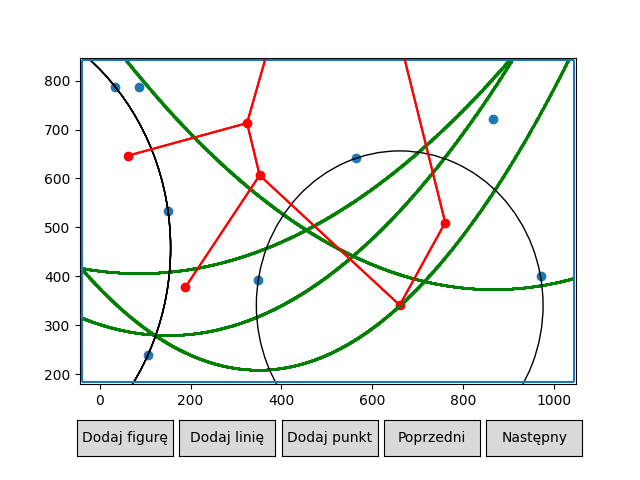

In [171]:
%matplotlib notebook

# plot = Plot(points = [PointsCollection(test)], lines = [LinesCollection(l), LinesCollection(b)])
plot = Plot(scenes=visualization.scenes)

plt.xlim = ((lowerLeft.x-5, upperRight.x+5))
plt.ylim = ((lowerLeft.y-5, upperRight.y+5))
plot.draw(False)